In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.utils import shuffle
from sklearn import set_config, metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, LeaveOneGroupOut, KFold, GroupKFold, StratifiedGroupKFold

In [3]:
sns.set_context("talk")
sns.set_theme(style='white')
sns.set_style("darkgrid")
sns.set_palette('bright')

In [4]:
#df_main_author = pd.read_csv(r'../data/df_awards_authors_5000.csv')
df_main_author = pd.read_csv(r'../data/df_awards_MOTIFS_authors_5000.csv')

df_main_author.set_index("Unnamed: 0", inplace = True)
df_main_author = df_main_author.replace(np.nan, 0)

In [5]:
df_main_author.AWARD.value_counts()

AWARD
not_awarded    1347
awarded          88
Name: count, dtype: int64

In [62]:
df_main_author.columns[4150:]

Index(['NOUN_de_son_NOUN_le', 'VERB_à_le_NOUN_un', 'NOUN_de_NOUN_VERB_à',
       'VERB_à_le_NOUN_ce', 'que_il_avoir_VERB_le', 'le_NOUN_par_le_NOUN',
       'avoir_VERB_à_le_NOUN', 'AWARD', 'auteur'],
      dtype='object')

In [33]:
def plot_coefficients(coefs, feature_names, top_features):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    #top_positive_coefficients = np.array(coefs)[np.array(coefs)>0.005]
    #top_negative_coefficients = np.array(coefs)[np.array(coefs)<-0.005]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    fig, ax = plt.subplots(figsize=(15, 5))

    colors = ['awarded' if c < 0 else 'not_awarded' for c in coefs[top_coefficients]]
    feature_names = np.array(feature_names)
    zipped = list(zip(feature_names, coefs[top_coefficients], colors))
    df_tmp = pd.DataFrame(zipped, columns=['features', 'coefs', 'colors'])
    
    sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())

    ax.set_xlabel('Feature name', fontsize = 30)
    ax.set_ylabel('Coefficient score', fontsize = 30)
    
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    #plt.title("Best classification coefficients")
    plt.savefig('../img/coefs_linear_svm_canon_novels.png', format='png', bbox_inches='tight', dpi=400)

    plt.show()
    


In [15]:
def KF_canonized(df_main, n_splits=5, probas=False, kernel='rbf', top_features=20):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    ALL_PROBAS, ALL_INDEX = [], [] # lists of all test probas and all test index
    
    pipe = make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=probas, kernel=kernel))#{"canon":10, "non_canon":1}
    kf = KFold(n_splits)
    
    for (train_index, test_index) in kf.split(df_main.drop(['auteur', 'AWARD'], axis=1), df_main['AWARD']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'AWARD'], axis=1)
            y_train = train['AWARD']
            X_test = test.drop(['auteur', 'AWARD'], axis=1)
            y_test = test['AWARD']
            
            pipe.fit(X_train, y_train)               
            preds = pipe.predict(X_test)
            
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)
                        
            if probas==True:
                probs = pipe.predict_proba(X_test)[:,0]
                ALL_PROBAS.extend(probs)

            
    cm = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS)
    cm.figure_.savefig('../img/BEST_MOTIFS_CM.png')
    
    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)
    
    if kernel == 'linear' and probas==True:
        coefs = pipe.named_steps['svc'].coef_
        df_coefs = pd.DataFrame(coefs, columns=X_train.columns)
        df_coefs.to_csv("../outputs/coefs_novel_scale.csv")
        plot_coefficients(*coefs, X_train.columns, top_features)

        df_results = pd.DataFrame()
        
        df_results['metadata'] = ALL_GT
        df_results['proba_AWARD'] = ALL_PROBAS
        df_results['prediction']= ALL_PREDS
        df_results['index']= ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
        
        return pipe, df_scores, bas, df_coefs, df_results.set_index('index')

    return pipe, df_scores, bas

In [16]:
def GKF_canonized(df_main, n_splits=5, probas=False, kernel='rbf'):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    ALL_PROBAS, ALL_INDEX = [], [] # lists of all test probas and all test index
    
    pipe = make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=probas, kernel=kernel))#{"canon":10, "non_canon":1}
    gkf = GroupKFold(n_splits)
    
    for (train_index, test_index) in gkf.split(df_main.drop(['auteur', 'AWARD'], axis=1), df_main['AWARD'], df_main['auteur']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'AWARD'], axis=1)
            y_train = train['AWARD']
            X_test = test.drop(['auteur', 'AWARD'], axis=1)
            y_test = test['AWARD']
            
            pipe.fit(X_train, y_train)               
            preds = pipe.predict(X_test)
            
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)
                        
            if probas==True:
                probs = pipe.predict_proba(X_test)[:,0]
                ALL_PROBAS.extend(probs)

            
    cm = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS)
    cm.figure_.savefig('../img/BEST_MOTIFS_CM.png')
    
    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)
    
    if kernel == 'linear' and probas==True:
        coefs = pipe.named_steps['svc'].coef_
        df_coefs = pd.DataFrame(coefs, columns=X_train.columns)
        df_coefs.to_csv("../outputs/coefs_novel_scale.csv")
        plot_coefficients(*coefs, X_train.columns, 20)

        df_results = pd.DataFrame()
        
        df_results['metadata'] = ALL_GT
        df_results['proba_AWARD'] = ALL_PROBAS
        df_results['prediction']= ALL_PREDS
        df_results['index']= ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
        
        return pipe, df_scores, bas, df_coefs, df_results.set_index('index')

    return pipe, df_scores, bas

In [17]:
def ratio_truncate(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = df_res.AWARD.value_counts(normalize=True).awarded
    index_noncanon = df_res[df_res['AWARD']  == 'not_awarded'].index 
    i, j = 0, 20
    
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=10
        ratio_temp = df_res.AWARD.value_counts(normalize=True).awarded

    return shuffle(df_res)

In [18]:
def N_canonizer_sizeopti(df_main, N_fold=5, N_sample=10, ratio=0.5):
    list_res, all_bas = [], []
    for i in tqdm(range(N_sample)):
        df_sizeopti_last = ratio_truncate(df_main, ratio)
        pipe, results, bas = GKF_canonized(df_sizeopti_last, N_fold)
        list_res.append(results)
        all_bas.append(bas)
    all_results = pd.concat(list_res).groupby(level=0).mean()
    print(sum(all_bas)/len(all_bas))
    return pipe, all_results, all_bas # return last pipe

In [39]:
df_sizeopti = ratio_truncate(df_main_author, 0.5)

0.7367424242424242


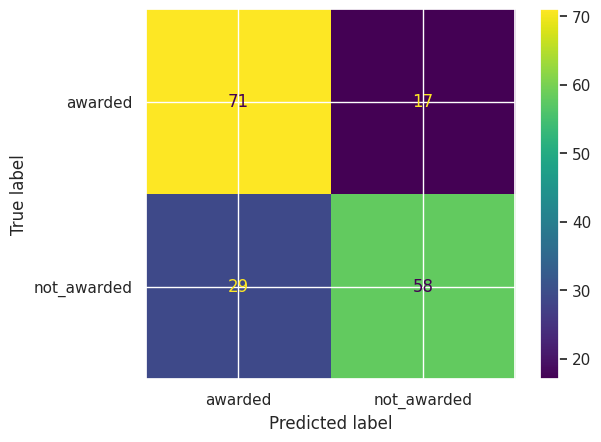

In [40]:
pipe, df_scores, bas = KF_canonized(df_sizeopti, probas=True, top_features=2000)

0.6797283176593522


/tmp/ipykernel_29142/907522143.py:15: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


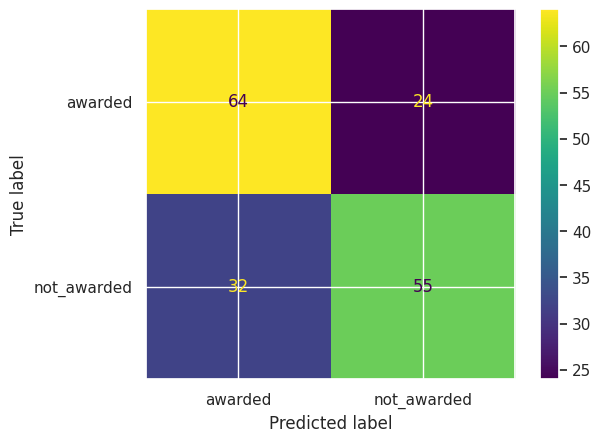

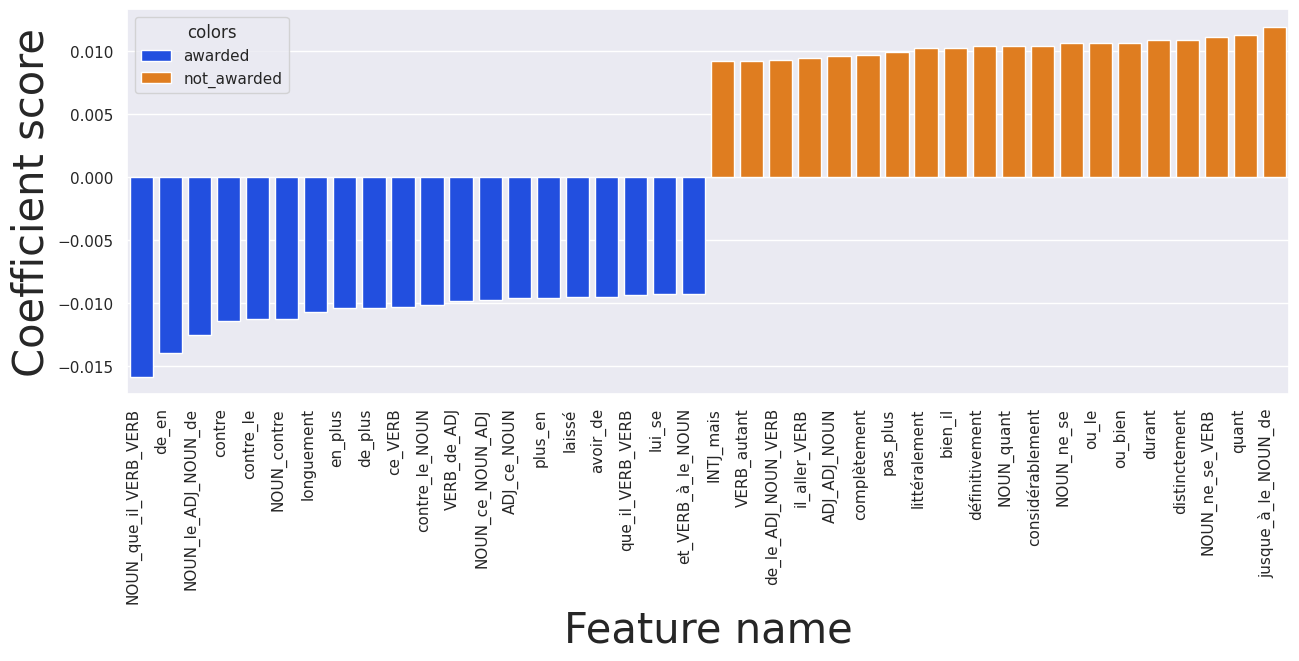

In [41]:
pipe, df_scores, bas, df_coefs, df_results = KF_canonized(df_sizeopti, probas=True,  kernel="linear", top_features=20)

In [66]:
df_uni = df_sizeopti.iloc[:,:298]
df_uni['auteur']=df_sizeopti['auteur']
df_uni['AWARD']=df_sizeopti['AWARD']

0.7368730407523512


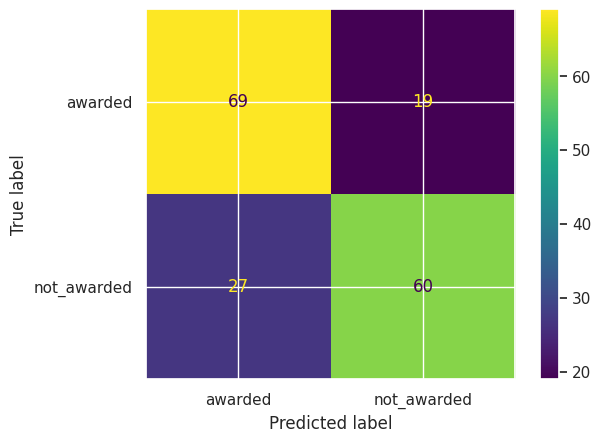

In [67]:
pipe, df_scores, bas = KF_canonized(df_uni, probas=True, top_features=20)

0.7368077324973876


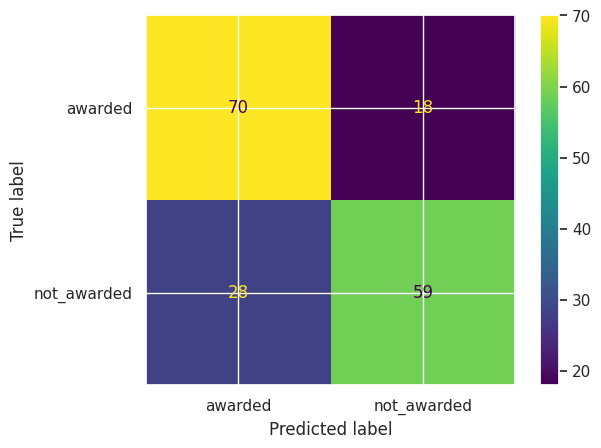

In [75]:
df_bi = df_sizeopti.iloc[:,299:1219]
df_bi['auteur']=df_sizeopti['auteur']
df_bi['AWARD']=df_sizeopti['AWARD']
pipe, df_scores, bas = KF_canonized(df_bi, probas=True, top_features=20)

0.7309952978056427


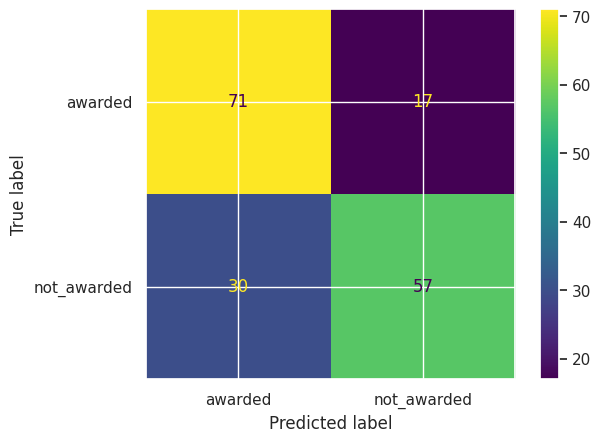

In [89]:
df_tri = df_sizeopti.iloc[:,1220:2217]
df_tri['auteur']=df_sizeopti['auteur']
df_tri['AWARD']=df_sizeopti['AWARD']
pipe, df_scores, bas = KF_canonized(df_tri, probas=True, top_features=20)

0.6856060606060606


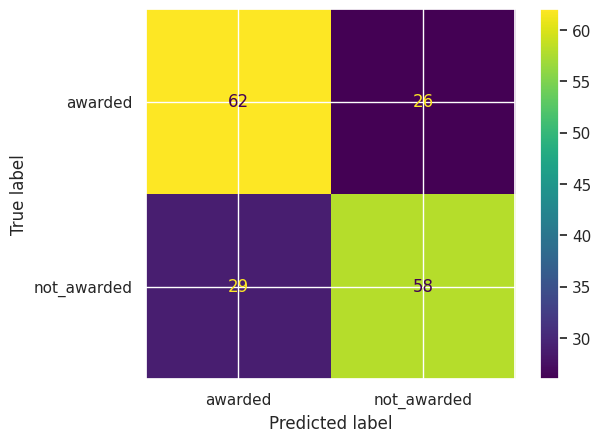

In [96]:
df_quadri = df_sizeopti.iloc[:,2217:3212]
df_quadri['auteur']=df_sizeopti['auteur']
df_quadri['AWARD']=df_sizeopti['AWARD']
pipe, df_scores, bas = KF_canonized(df_quadri, probas=True, top_features=20)

0.7085292580982236


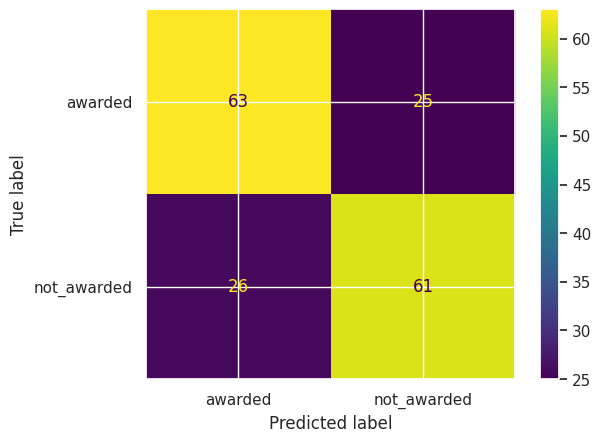

In [100]:
df_cinq = df_sizeopti.iloc[:,3213:4157]
df_cinq['auteur']=df_sizeopti['auteur']
df_cinq['AWARD']=df_sizeopti['AWARD']
pipe, df_scores, bas = KF_canonized(df_cinq, probas=True, top_features=20)

In [ ]:
# unigram - 0-298
# bigram - 299-1219
# trigram - 1220-2217
# quadrigram - 2218-3212
# quenqagram - 3213-4157

In [109]:
df_concat = pd.concat([df_sizeopti.iloc[:,0:198], df_sizeopti.iloc[:,299:496], df_sizeopti.iloc[:,1220:1418], df_sizeopti.iloc[:,2218:2416], df_sizeopti.iloc[:,3213:3411]], axis=1)

In [110]:
df_concat

,falloir,il,VERB,que,chez,NOUN,le,être,sur,qui,...,son_NOUN_VERB_le_NOUN,le_NOUN_un_NOUN_VERB,VERB_il_VERB_un_NOUN,NOUN_de_NOUN_et_il,NOUN_avec_un_ADJ_NOUN,se_VERB_à_le_VERB,VERB_par_un_NOUN_de,il_ne_avoir_pas_VERB,VERB_son_NOUN_à_le,son_NOUN_à_le_NOUN
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2003_Angot-Christine_Peau-d-ane,0.001526,0.047076,0.107648,0.026912,0.000723,0.202763,0.102828,0.024422,0.002972,0.012371,...,0.000000,0.000080,0.000161,0.000000,0.000161,0.000161,0.000080,0.000482,0.000000,0.000080
1910_Rolland-Romain_Jean-Christophe_Tome-VIII-Les-amies,0.001061,0.069231,0.131032,0.022847,0.001247,0.178393,0.094218,0.024565,0.003117,0.011929,...,0.000067,0.000051,0.000101,0.000152,0.000051,0.000354,0.000067,0.000320,0.000253,0.000253
2013_Lemaitre-Pierre_Au-revoir-la-haut,0.001482,0.046646,0.130030,0.018703,0.000599,0.200989,0.100262,0.022885,0.005011,0.007125,...,0.000162,0.000061,0.000141,0.000067,0.000047,0.000424,0.000081,0.000189,0.000175,0.000317
1918_Genestoux-Magdeleine-du_Noemie-Hollemechette-Journal-d-une-petite-refugiee-belge,0.001602,0.078664,0.128910,0.023865,0.000869,0.192106,0.084750,0.030614,0.004759,0.010456,...,0.000137,0.000069,0.000069,0.000183,0.000092,0.000572,0.000092,0.000183,0.000366,0.000526
2009_N-Diaye-Marie_Trois-femmes-puissantes,0.000401,0.055942,0.126479,0.028814,0.001038,0.182822,0.091977,0.016708,0.004814,0.007316,...,0.000283,0.000106,0.000059,0.000059,0.000059,0.000413,0.000024,0.000236,0.000307,0.000507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938_Nizan-Paul_La-Conspiration,0.001399,0.048890,0.110701,0.024239,0.000754,0.218796,0.109809,0.018395,0.005048,0.011221,...,0.000082,0.000082,0.000082,0.000096,0.000082,0.000151,0.000082,0.000192,0.000206,0.000384
1956_Simenon-Georges_Un-echec-de-Maigret,0.000592,0.069317,0.126736,0.022666,0.000808,0.188139,0.098094,0.029504,0.003473,0.008587,...,0.000188,0.000000,0.000162,0.000108,0.000000,0.000215,0.000027,0.000565,0.000162,0.000323
1993_Bergounioux-Pierre_Le-Grand-Sylvain,0.001187,0.038215,0.115753,0.030857,0.000237,0.193211,0.126751,0.023024,0.004510,0.010365,...,0.000317,0.000079,0.000000,0.000079,0.000000,0.000079,0.000079,0.000396,0.000237,0.000396


0.6967737722048066


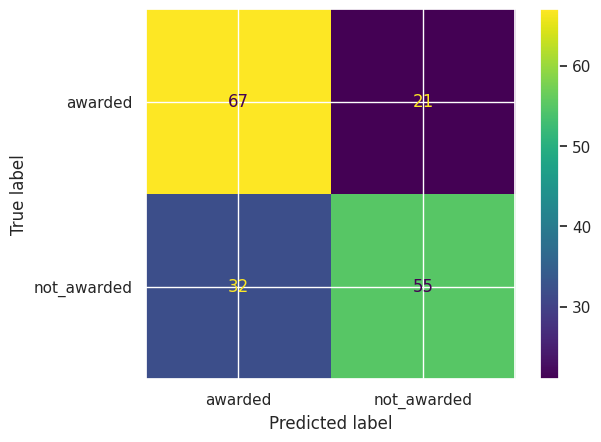

In [111]:
df_concat['auteur']=df_sizeopti['auteur']
df_concat['AWARD']=df_sizeopti['AWARD']
pipe, df_scores, bas = KF_canonized(df_concat, probas=True, top_features=20)

In [43]:
df_trie = df_coefs.iloc[:, np.argsort(df_coefs.iloc[0])]

In [44]:
df_trie

,NOUN_que_il_VERB_VERB,de_en,NOUN_le_ADJ_NOUN_de,contre,contre_le,NOUN_contre,longuement,en_plus,de_plus,ce_VERB,...,NOUN_quant,considérablement,NOUN_ne_se,ou_le,ou_bien,durant,distinctement,NOUN_ne_se_VERB,quant,jusque_à_le_NOUN_de
0,-0.015807,-0.013909,-0.012531,-0.011388,-0.01125,-0.011247,-0.010683,-0.010374,-0.01036,-0.010264,...,0.010401,0.010409,0.010615,0.010615,0.010618,0.010831,0.010861,0.011068,0.011261,0.011919


In [54]:
filtered_df = df_trie.applymap(lambda x: x if x > 0.0075 or x < -0.0075 else None)

In [55]:
filtered_df = filtered_df.dropna(axis=1, how='all')

In [58]:
filtered_df.to_csv("PEDROS_MOTIFS.csv")

0.7367424242424242


/tmp/ipykernel_6488/2146443360.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


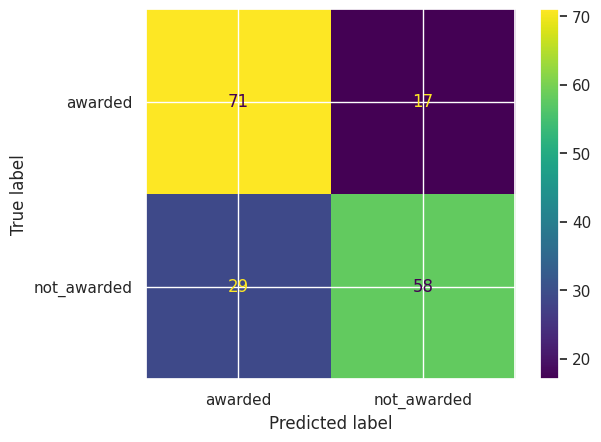

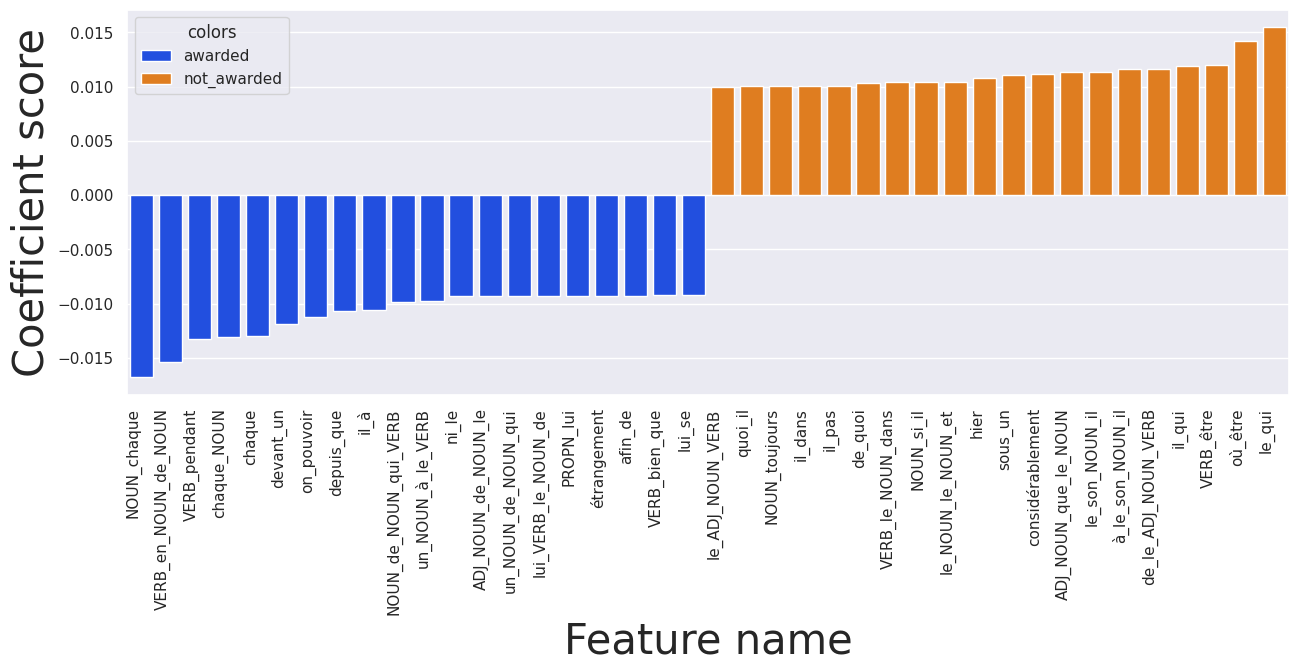

In [84]:
pipe, df_scores, bas, df_coefs, df_results = KF_canonized(df_sizeopti, probas=True, kernel="linear")

0.7368077324973876


/tmp/ipykernel_6488/2146443360.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


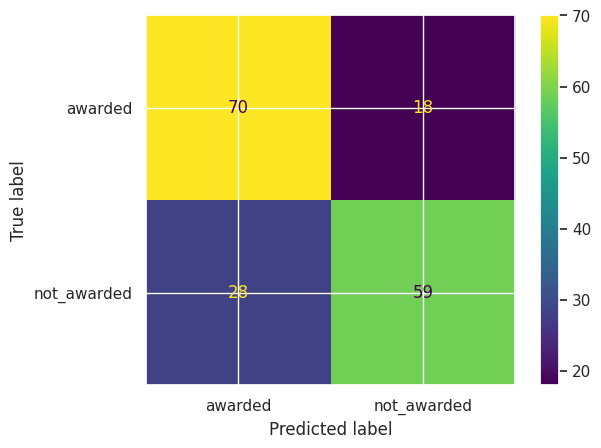

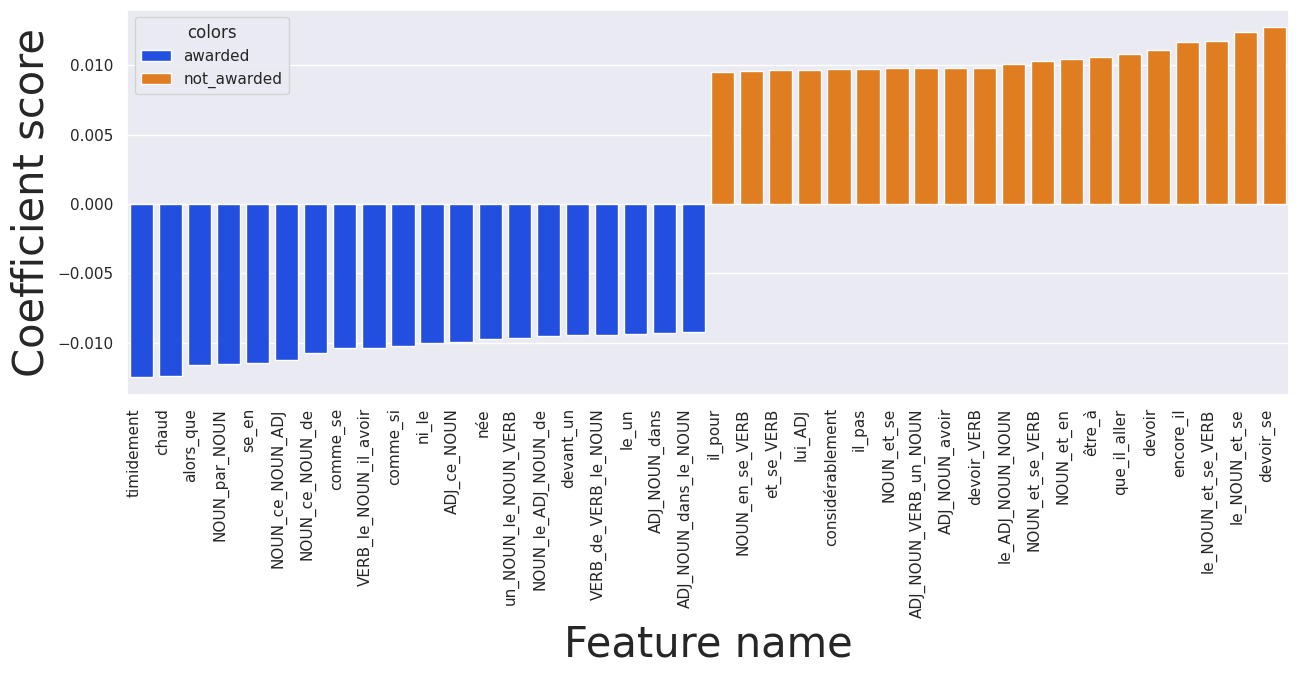

In [21]:
pipe, df_scores, bas, df_results = KF_canonized(df_sizeopti, probas=True, kernel="linear")

In [79]:
df_coefs.to_csv("../outputs/BEST_MOTIFS_COEFS.csv")

In [80]:
df_scores.to_csv("../outputs/BEST_MOTIFS_METRICS.csv")

In [81]:
df_results.to_csv("../outputs/BEST_MOTIFS_CONFUSION_MATRIX.csv")

In [78]:
bas

0.7367424242424242

In [41]:
pipe.classes_

array(['awarded', 'not_awarded'], dtype=object)

0.7654127481713688


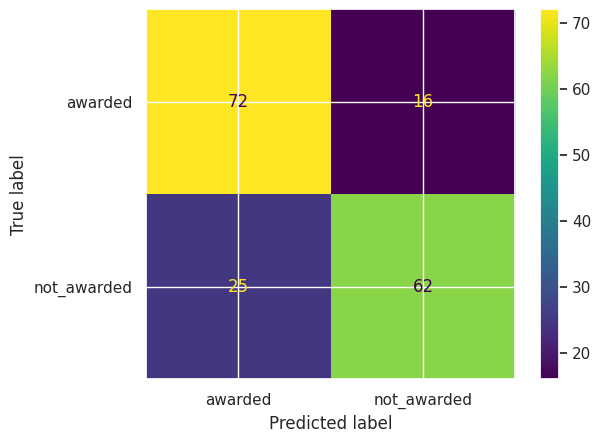

In [14]:
pipe, df_scores, bas, df_results = KF_canonized(df_sizeopti, probas=True)

0.7541144200626959


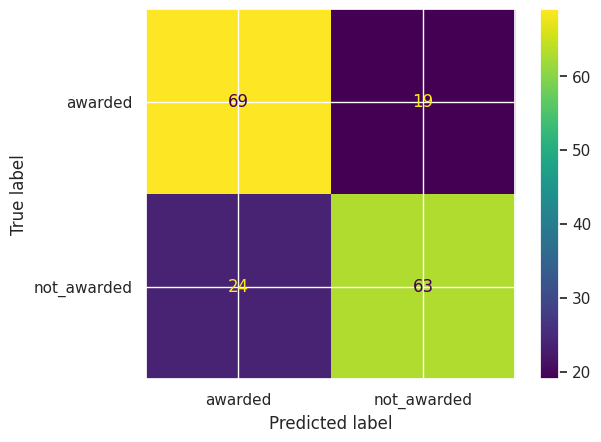

In [37]:
pipe, df_scores, bas, df_results = KF_canonized(df_sizeopti, probas=True)

0.7481713688610241


/tmp/ipykernel_31648/2146443360.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


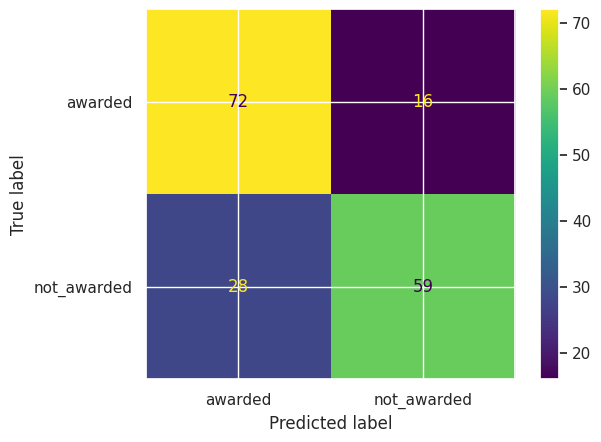

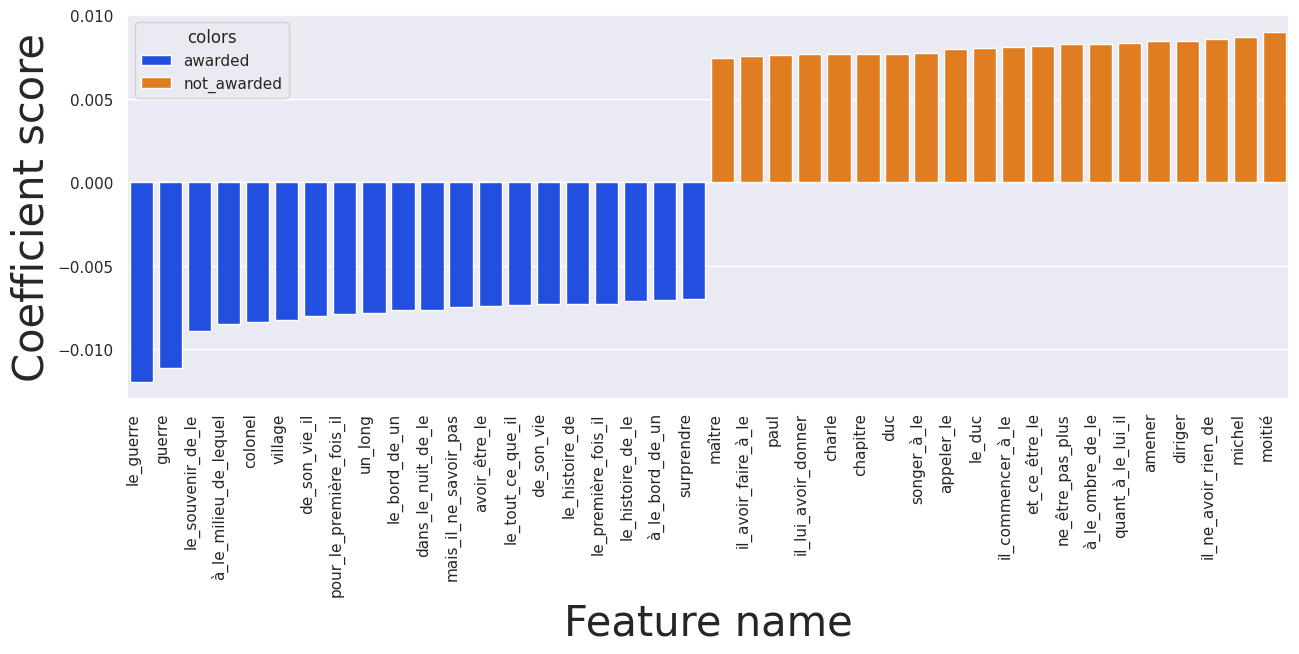

In [15]:
pipe, df_scores, bas, df_results = KF_canonized(df_sizeopti, probas=True, kernel='linear')

In [28]:
df_concat = pd.concat([df_sizeopti.iloc[:, 0:700], df_sizeopti.iloc[:, 1000:1800], df_sizeopti.iloc[:, 2000:2800], df_sizeopti.iloc[:, 3000:3800], df_sizeopti.iloc[:, 4000:4800]],  axis=1)
df_concat['AWARD']=df_sizeopti['AWARD']
df_concat['auteur']=df_sizeopti['auteur']

0.7596656217345873


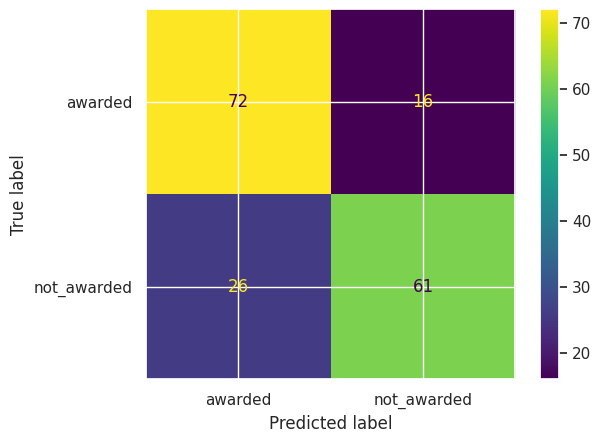

In [29]:
pipe, df_scores, bas = KF_canonized(df_concat)

0.7368730407523512


/tmp/ipykernel_31648/2146443360.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


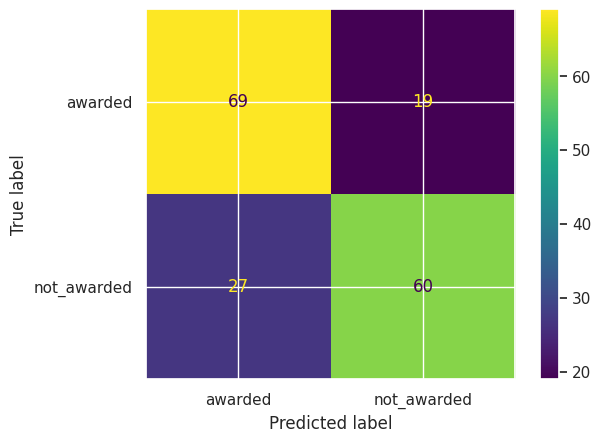

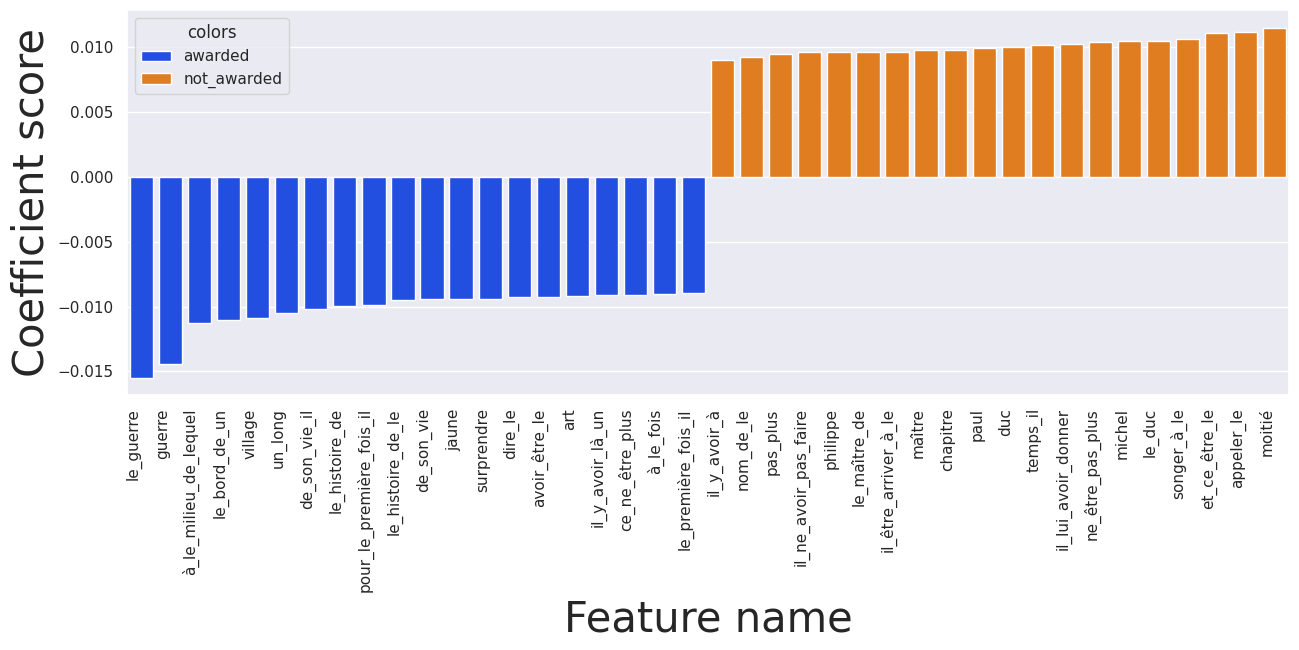

In [30]:
pipe, df_scores, bas, rez = KF_canonized(df_concat, kernel="linear")

# GroupKFold

0.7029780564263323


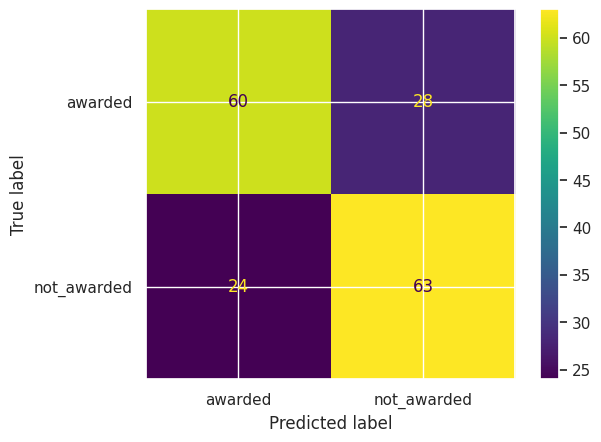

In [23]:
pipe, df_scores, bas, df_results = GKF_canonized(df_sizeopti, probas=True)

0.6741118077324975


/tmp/ipykernel_46150/2146443360.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


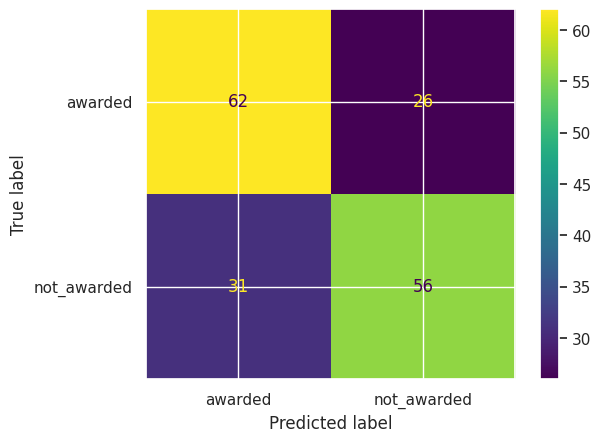

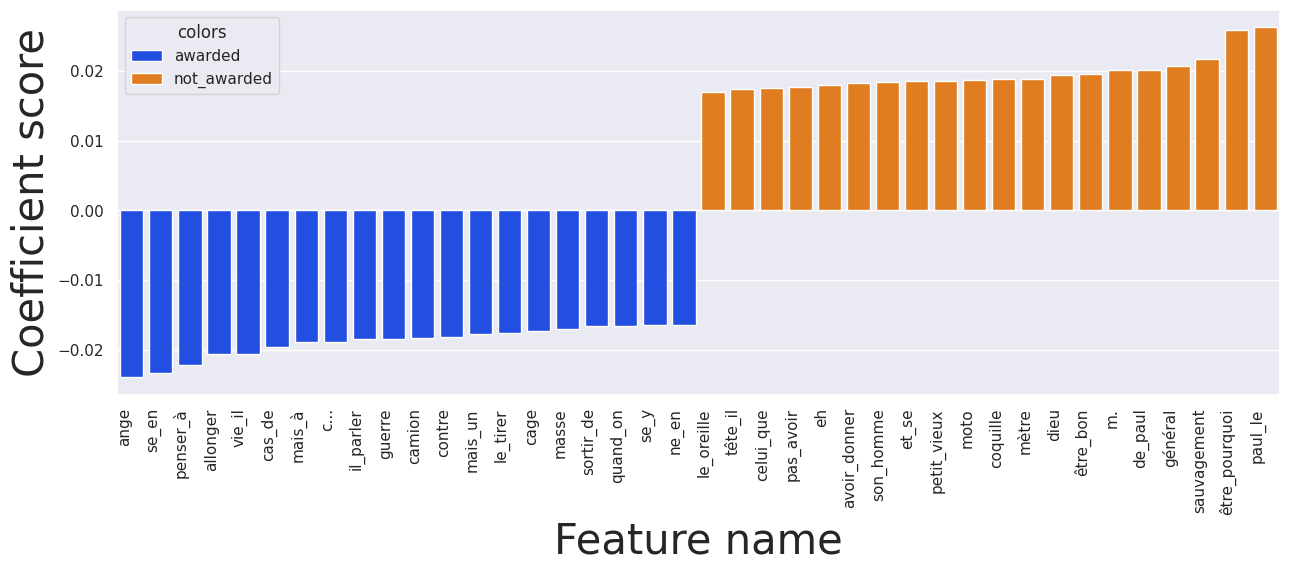

In [24]:
pipe, df_scores, bas, df_results = GKF_canonized(df_sizeopti, probas=True, kernel='linear')